In [9]:
import sys, os
from csv import DictWriter

import numpy as np
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

import torch_optimizer as optim_all

import pynumdiff

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

In [10]:
def build_true_model(x, t, omega=1., zeta=0.05, F0=1., 
                     forcing_freq=1.2, friction_force_ratio=0.5):
    """
    A function that gets the displacement, velocity and time as an input, and returns the true vector field output (velocity and acceleration)

    Parameters
    ----------
    x : numpy.ndarray 
        a 2D array containing the displacement in the first column and the velocity in the second one
    t : numpy.ndarray
        an 1D array containing the discrete time values 
    omega : float
        the natural frequency of the oscillator (contaminated with noise)
    zeta : float
        the damping ratio of the oscillator (contaminated with noise)
    F0 : float
        the excitation amplitude
    forcing_freq : float
        the frequency of the harmoning excitation
    friction_force_ratio : float
        the ratio of friction amplitude over mass
    Returns
    -------
    numpy.ndarray
        a 2D array with the two vector field values, velocity as first column and acceleration as second, for the given input x and t
    """
    return [
        x[1],
        - 2 * omega * zeta * x[1]
        - omega ** 2 * x[0]
        - friction_force_ratio * np.sign(x[1])
        + F0 * np.cos(forcing_freq * t)
    ]

In [11]:
@dataclass
class parameters:
    id: str = "89"
    num_epochs = 1000
    num_iter = 3
    lr = 1e-2
    weightdecay = 0.0
    timefinal = 50.0
    timestep: float = 1e-2
    tol_coeffs: float = 5e-2

    true_omega = 1.0
    true_zeta = 0.05

    omega: float = 1.0
    zeta: float = 0.05
    forcing_freq: float = 1.2
    F0: float = 1.
    friction_force_ratio: float = 0.5

    noisy_measure_flag: bool = True
    noise_level: float = 5e-2
    noisy_input_flag: bool = True
    omega_noise: float = 5e-2
    zeta_noise: float = 2e-1

    poly_order: int = 3
    phases: np.ndarray = np.arange(1., 2.01, 0.1)
    sgn_flag: bool = False
    
Params = parameters()

num_real = 1

In [12]:
#Generate (noisy) measurements - Training Data
ts = np.arange(0, Params.timefinal, Params.timestep)

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
sol = solve_ivp(
    lambda t, x: build_true_model(x, t, omega=Params.true_omega, zeta=Params.true_zeta, 
                                friction_force_ratio=Params.friction_force_ratio, 
                                forcing_freq=Params.forcing_freq), 
    t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts
    )

x_denoised = np.transpose(sol.y)

In [13]:
x = np.random.normal(loc=x_denoised, scale=Params.noise_level * np.abs(x_denoised), size=x_denoised.shape)

In [14]:
displs = x[:, 0]
vels = x[:, 1]

In [15]:
# velsAutodiff = np.gradient(displs, ts, edge_order=2)

# plt.plot(ts, vels, linewidth=3, alpha=0.6, color='cyan', label='Exact')
# plt.plot(ts, velsAutodiff, 'k--', label='AutoDiff')
# plt.legend()
# plt.show()

In [16]:
params = [0.05]
x_hat, dxdt_hat = pynumdiff.linear_model.spectraldiff(displs, Params.timestep, params)

In [37]:
params = [20]


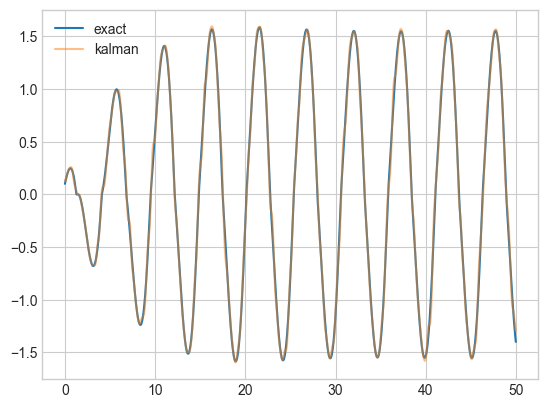

In [31]:
# x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(displs, Params.timestep)

_, dx_kal = pynumdiff.kalman_smooth.constant_acceleration(displs, Params.timestep, [Params.noise_level**2, 5e-1])
# _, dx_smoothfd = pynumdiff.smooth_finite_difference.gaussiandiff(displs, Params.timestep, [20], options={'iterate': False})

plt.plot(ts, x_denoised[:, 1], label='exact')
plt.plot(ts, dx_kal, alpha=0.5, label='kalman')
# plt.plot(ts, dx_smoothfd, alpha=0.8, label='smooth fd')
plt.legend()
plt.show()

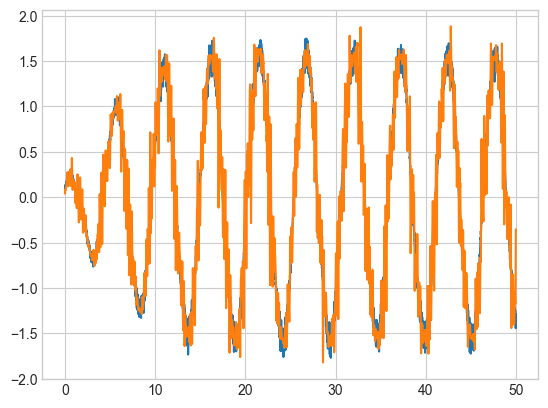

In [38]:
plt.plot(ts, vels)
plt.plot(ts, dxdt_hat)
plt.show()